# Implementing Simple Linear Function Fitting

Author: [Yi Yang](https://github.com/helloyesterday)&nbsp;&nbsp;&nbsp;&nbsp;Editor: [Mingfu Lv](https://gitee.com/lvmingfu)

`Linux` `Windows` `Ascend` `GPU` `CPU` `Whole Process` `Beginner` `Intermediate` `Expert`

[![](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/training/source_en/quick_start/linear_regression.ipynb)

## Overview

Regression algorithms usually use a series of properties to predict a value, and the predicted values are consecutive. For example, the price of a house is predicted based on some given feature data of the house, such as area and the number of bedrooms; or future temperature conditions are predicted by using the temperature change data and satellite cloud images in the last week. If the actual price of the house is CNY5 million, and the value predicted through regression analysis is CNY4.99 million, the regression analysis is considered accurate. For machine learning problems, common regression analysis includes linear regression, polynomial regression, and logistic regression. This example describes the linear regression algorithms and how to use MindSpore to perform linear regression AI training.

The whole process is as follows:

1. Generate datasets.
2. Define a training network.
3. Define and associate the forward and backward propagation networks.
4. Prepare for fitting process visualization.
5. Perform training.

> This document is applicable to CPU, GPU and Ascend environments. The source code address of this example: <https://gitee.com/mindspore/docs/blob/master/tutorials/tutorial_code/linear_regression.py>.

## Environment Preparation

Complete MindSpore running configuration.

In [1]:
from mindspore import context

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

`GRAPH_MODE`: graph mode.

`device_target`: sets the MindSpore training hardware to CPU.

> Third-party support package: `matplotlib`. If this package is not installed, run the `pip install matplotlib` command to install it first.

## Generating Datasets

### Defining the Dataset Generation Function

`get_data` is used to generate training and test datasets. Since linear data is fitted, the required training datasets should be randomly distributed around the objective function. Assume that the objective function to be fitted is $f(x)=2x+3$. $f(x)=2x+3+noise$ is used to generate training datasets, and `noise` is a random value that complies with standard normal distribution rules.

In [2]:
import numpy as np

def get_data(num, w=2.0, b=3.0):
    for _ in range(num):
        x = np.random.uniform(-10.0, 10.0)
        noise = np.random.normal(0, 1)
        y = x * w + b + noise
        yield np.array([x]).astype(np.float32), np.array([y]).astype(np.float32)

Use `get_data` to generate 50 groups of test data and visualize them.

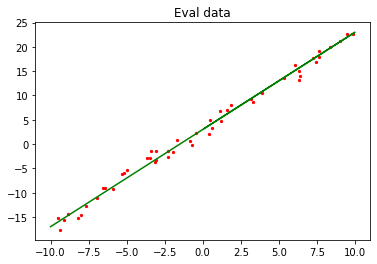

In [3]:
import matplotlib.pyplot as plt

eval_data = list(get_data(50))
x_target_label = np.array([-10, 10, 0.1])
y_target_label = x_target_label * 2 + 3
x_eval_label,y_eval_label = zip(*eval_data)

plt.scatter(x_eval_label, y_eval_label, color="red", s=5)
plt.plot(x_target_label, y_target_label, color="green")
plt.title("Eval data")
plt.show()

In the preceding figure, the green line indicates the objective function, and the red points indicate the verification data `eval_data`.

### Defining the Data Argumentation Function

Use the MindSpore data conversion function `GeneratorDataset` to convert the data type to that suitable for MindSpore training, and then use `batch` and `repeat` to perform data argumentation. The operation is described as follows:

- `ds.GeneratorDataset`: converts the generated data into a MindSpore dataset and saves the x and y values of the generated data to arrays of `data` and `label`.
- `batch`: combines `batch_size` pieces of data into a batch.
- `repeat`: multiplies the number of datasets.

In [4]:
from mindspore import dataset as ds

def create_dataset(num_data, batch_size=16, repeat_size=1):
    input_data = ds.GeneratorDataset(list(get_data(num_data)), column_names=['data','label'])
    input_data = input_data.batch(batch_size)
    input_data = input_data.repeat(repeat_size)
    return input_data

Use the dataset argumentation function to generate training data and view the training data format.

In [5]:
data_number = 1600
batch_number = 16
repeat_number = 1

ds_train = create_dataset(data_number, batch_size=batch_number, repeat_size=repeat_number) 
print("The dataset size of ds_train:", ds_train.get_dataset_size())
dict_datasets = next(ds_train.create_dict_iterator())

print(dict_datasets.keys())
print("The x label value shape:", dict_datasets["data"].shape)
print("The y label value shape:", dict_datasets["label"].shape)

The dataset size of ds_train: 100
dict_keys(['data', 'label'])
The x label value shape: (16, 1)
The y label value shape: (16, 1)


Use the defined `create_dataset` to perform argumentation on the generated 1600 data records and set them into 100 datasets with the shape of 16 x 1.

## Defining the Training Network

In MindSpore, use `nn.Dense` to generate a linear function model of single data input and single data output.

$$f(x)=wx+b\tag{1}$$

Use the Normal operator to randomly initialize the weights $w$ and $b$.

In [6]:
from mindspore.common.initializer import Normal
from mindspore import nn

class LinearNet(nn.Cell):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc = nn.Dense(1, 1, Normal(0.02), Normal(0.02))
        
    def construct(self, x):
        x = self.fc(x)
        return x

Call the network to view the initialized model parameters.

In [7]:
net = LinearNet()
model_params = net.trainable_params()
for param in model_params:
    print(param, param.asnumpy())

Parameter (name=fc.weight) [[-0.02573255]]
Parameter (name=fc.bias) [0.01332773]


After initializing the network model, visualize the initialized network function and training dataset to understand the model function before fitting.

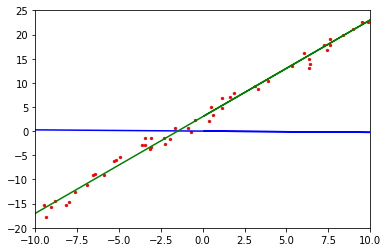

In [8]:
from mindspore import Tensor

x_model_label = np.array([-10, 10, 0.1])
y_model_label = (x_model_label * Tensor(model_params[0]).asnumpy()[0][0] +
                 Tensor(model_params[1]).asnumpy()[0])
plt.axis([-10, 10, -20, 25])
plt.scatter(x_eval_label, y_eval_label, color="red", s=5)
plt.plot(x_model_label, y_model_label, color="blue")
plt.plot(x_target_label, y_target_label, color="green")
plt.show()

As shown in the preceding figure, the initialized model function in blue differs greatly from the objective function in green.

## Defining and Associating the Forward and Backward Propagation Networks

Define the loss function of the model. The mean squared error (MSE) method is used to determine the fitting effect. The smaller the MSE value difference, the better the fitting effect. The loss function formula is as follows:

$$J(w)=\frac{1}{2m}\sum_{i=1}^m(h(x_i)-y^{(i)})^2\tag{2}$$

Assuming that the $i$th data record in the training data is $(x_i,y^{(i)})$, parameters in formula 2 are described as follows:

- $J(w)$ specifies the loss value.

- $m$ specifies the amount of sample data. In this example, the value of $m$ is `batch_number`.

- $h(x_i)$ is a predicted value obtained after the $x_i$ value of the $i$th data record is substituted into the model network (formula 1).

- $y^{(i)}$ is the $y^{(i)}$ value (label value) of the $i$th data record.

### Defining the Forward Propagation Network

A forward propagation network consists of two parts:

1. Bring parameters into the model network to obtain the predicted value.
2. Use the predicted value and training data to compute the loss value.

The following method is used in MindSpore:

In [9]:
net = LinearNet()
net_loss = nn.loss.MSELoss()

### Defining the Backward Propagation Network

The objective of the backward propagation network is to continuously change the weight value to obtain the minimum loss value. Generally, the weight update formula is used in the linear network:

$$w_{t}=w_{t-1}-\alpha\frac{\partial{J(w_{t-1})}}{\partial{w}}\tag{3}$$

Parameters in formula 3 are described as follows:

- $w_{t}$ indicates the weight after training steps.
- $w_{t-1}$ indicates the weight before training steps.
- $\alpha$ indicates the learning rate.
- $\frac{\partial{J(w_{t-1}\ )}}{\partial{w}}$ is the differentiation of the loss function to the weight $w_{t-1}$.

After all weight values in the function are updated, transfer the values to the model function. This process is the backward propagation. To implement this process, the optimizer function in MindSpore is required.

In [10]:
opt = nn.Momentum(net.trainable_params(), learning_rate=0.005, momentum=0.9)

### Associating the Forward and Backward Propagation Networks

After forward propagation and backward propagation are defined, call the `Model` function in MindSpore to associate the previously defined networks, loss functions, and optimizer function to form a complete computing network.

In [11]:
from mindspore import Model

model = Model(net, net_loss, opt)

## Preparation for Fitting Process Visualization

### Defining the Visualization Function

To make the entire training process easier to understand, the test data, objective function, and model network of the training process need to be visualized. The following defines a visualization function which is called after each training step to display a fitting process of the model network.

In [12]:
import matplotlib.pyplot as plt
import time

def plot_model_and_datasets(net, eval_data):
    weight = net.trainable_params()[0]
    bias = net.trainable_params()[1]
    x = np.arange(-10, 10, 0.1)
    y = x * Tensor(weight).asnumpy()[0][0] + Tensor(bias).asnumpy()[0]
    x1, y1 = zip(*eval_data)
    x_target = x
    y_target = x_target * 2 + 3

    plt.axis([-11, 11, -20, 25])
    plt.scatter(x1, y1, color="red", s=5)
    plt.plot(x, y, color="blue")
    plt.plot(x_target, y_target, color="green")
    plt.show()
    time.sleep(0.2)

### Defining the Callback Function

MindSpore provides tools to customize the model training process. The following calls the visualization function in `step_end` to display the fitting process. For more information, see [Customized Debugging Information](https://www.mindspore.cn/tutorial/training/en/master/advanced_use/custom_debugging_info.html#callback).

- `display.clear_output`：Clear the printed content to achieve dynamic fitting effect.

In [13]:
from IPython import display
from mindspore.train.callback import Callback

class ImageShowCallback(Callback):
    def __init__(self, net, eval_data):
        self.net = net
        self.eval_data = eval_data

    def step_end(self, run_context):
        plot_model_and_datasets(self.net, self.eval_data)
        display.clear_output(wait=True)

## Performing Training

After the preceding process is complete, use the training parameter `ds_train` to train the model. In this example, `model.train` is called. The parameters are described as follows:

- `epoch`: Number of times that the entire dataset is trained.
- `ds_train`: Training dataset.
- `callbacks`: Required callback function during training.
- `dataset_sink_mode`: Dataset offload mode, which supports the Ascend and GPU computing platforms. In this example, this parameter is set to False for the CPU computing platform.

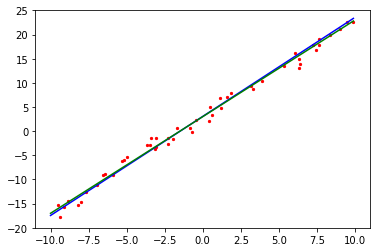

Parameter (name=fc.weight) [[2.0495164]]
Parameter (name=fc.bias) [3.0472562]


In [14]:
from mindspore.train.callback import LossMonitor

epoch = 1
imageshow_cb = ImageShowCallback(net, eval_data)
model.train(epoch, ds_train, callbacks=[imageshow_cb], dataset_sink_mode=False)

plot_model_and_datasets(net, eval_data)
for param in net.trainable_params():
    print(param, param.asnumpy())

After the training is complete, the weight parameters of the final model are printed. The value of weight is close to 2.0 and the value of bias is close to 3.0. As a result, the model training meets the expectation.

## Summary

We have learned the principles of the linear fitting algorithm, defined the corresponding algorithms in the MindSpore framework, understood the training process of such linear fitting models in MindSpore, and finally fitted a model function close to the objective function. In addition, you can adjust the dataset generation interval from (-10,10) to (-100,100) to check whether the weight values are closer to those of the objective function; adjust the learning rate to check whether the fitting efficiency changes; or explore how to use MindSpore to fit quadratic functions, such as $f(x)=ax^2+bx+c$, or higher-order functions.